<a href="https://colab.research.google.com/github/lexxai/goit_python_ds_hw_10/blob/main/goit_python_ds_hw_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from pathlib import Path
import pickle
import tensorflow as tf

from keras.models import Sequential, load_model, save_model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

from keras import optimizers, regularizers
from keras import losses, metrics
from keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoLocator, FixedLocator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score


## Завантажуємо датасет

In [5]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import fashion_mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [6]:
num_classes = 10 # загальна кількість класів
batch_size = 512 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
learning_rate = 0.005 # швидкість навчання нейронної мережі
num_features = x_train.shape[1] * x_train.shape[2] # кількість атрибутів вхідного вектора 28 * 28 = 784
num_features
ignore_saved_model = False
use_test_for_validate = True
model_zip_url = ""
model_zip = Path("goit_python_ds_hw_10_models.zip")
gdrive = Path("/content/drive/")
model_zip_gdrive = gdrive.joinpath("MyDrive/Colab Notebooks/GoIT/datasets/").joinpath(model_zip)

In [7]:
labels = ['T-shirt/top', 'Trouser', "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
labels_uk = ["Футболка/топ", "Штани", "Пуловер", "Сукня", "Пальто", "Босоніжки", "Сорочка", "Кросівки", "Сумка", "Черевики"]

In [8]:
# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

In [9]:
x_train.shape[1:]

(28, 28)

## Створення моделей НМ

In [10]:
n_hidden_1 = 256 # кількість нейронів 1-го шару
n_hidden_2 = 512 # кількість нейронів 2-го шару
n_hidden_3 = 16 # кількість нейронів 3-го шару

models = {}
models_his = {}
results = {}

validation_split = 0.0
validation_data = None

if use_test_for_validate:
  validation_data = (x_test, y_test)
else:
  validation_split = 0.1

In [30]:
# LOAD, SAVE MODLELS AND HISTORY

def load_models_gdrive(model_zip):
  print(model_zip)
  if model_zip.exists():
      !unzip -o "$model_zip"

def load_models_url(zip_url, model_zip):
 if not model_zip.exists():
    !wget $zip_url -O $model_zip
    if model_zip.exists():
      !unzip -o $model_zip

def save_all():
  for name in models:
    print(f"Save {name}")
    savemodel(name, models[name], models_his[name])
  zip_files()

def zip_files():
  print("Creating {model_zip}")
  !zip $model_zip *.keras *.pikle

def savemodel(name, model, history):
  filepath=Path(f"{name}_model.keras")
  model.save(filepath)
  filepath=Path(f"{name}_history.pikle")
  with filepath.open('wb') as f:
      pickle.dump(history, f)

def loadmodel(name):
  if ignore_saved_model:
    return None
  filepath=Path(f"{name}_model.keras")
  if filepath.exists():
    models[name] = load_model(filepath)
    filepath=Path(f"{name}_history.pikle")
    if filepath.exists():
      with filepath.open('rb') as f:
        return pickle.load(f)

# Fing saved epoch
def get_best_epoch_index(model_name):
  le = np.argmin(models_his[model_name].history['val_loss'])
  ta = np.argmax(models_his[model_name].history['val_accuracy'])
  return min(le, ta)

# Dynamic learn rate that depend of epoch
def scheduler(epoch, lr, thresh=7, thresh_lr=0.001):
  if epoch < thresh:
    return lr
  else:
    return thresh_lr
    # return lr * tf.math.exp(-0.1)

def scheduler_exp(epoch, lr, thresh=7):
  if epoch < thresh:
    return lr
  else:
    return lr * tf.math.exp(-0.1)


def get_callbacks(name, lr_sheduler=None):
    # Define early stopping callback
    early_stopping_acc = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                          patience=accurqcy_patience, verbose=1,
                                                          restore_best_weights=True)

    early_stopping_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=loss_patience, verbose=1,
                                                           restore_best_weights=True, start_from_epoch=4)


    # Define model checkpoint callback to save the best model
    model_checkpoint_acc = tf.keras.callbacks.ModelCheckpoint(filepath=f"{name}_best_model_acc.h5",
                                                           monitor='val_accuracy',
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           verbose=1)

    model_checkpoint_loss = tf.keras.callbacks.ModelCheckpoint(filepath=f"{name}_best_model_loss.h5",
                                                           monitor='val_loss',
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           verbose=1)

    if lr_sheduler is None:
      lr_sheduler = scheduler
    learing_rate = tf.keras.callbacks.LearningRateScheduler(lr_sheduler)


    return [early_stopping_loss, early_stopping_acc, model_checkpoint_acc, model_checkpoint_loss, learing_rate]


def compile_and_fit(model, name, batch_size=512, learning_rate=learning_rate, max_epochs=100, optimizer=None, shedule=None, verbose=False):
  history = loadmodel(name)
  if history is not None:
      return history
  print(f"{use_test_for_validate=}")
  if optimizer is None:
    optimizer = optimizers.Adam(learning_rate=learning_rate)
  model.compile(
      optimizer=optimizer,
      loss='sparse_categorical_crossentropy',
      metrics=["accuracy"]
  )
  model.summary()
  history = model.fit(
      x_train,
      y_train,
      epochs=max_epochs,
      batch_size=batch_size,
      validation_split=validation_split,
      validation_data=validation_data,
      callbacks=get_callbacks(name, shedule),
      use_multiprocessing=True,
      verbose=verbose
  )
  savemodel(name, model, history)
  return history

In [ ]:
# @title
# GOOGLE DRIVE MOUNT
from google.colab import drive

if not gdrive.exists():
  drive.mount(str(gdrive))

load_models_gdrive(model_zip_gdrive)

In [15]:
epochs = 60
accurqcy_patience = 10
loss_patience = 5


## Додаємо модель НМ версію 1 (IL-HL1-HL2-HL3-HL4-OL)

In [31]:
model_name = "Model_1"

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dense(n_hidden_1, activation='relu', name="Hidden_Layer_1"),
    Dense(n_hidden_2, activation='relu', kernel_regularizer=None, name="Hidden_Layer_2"),
    Dense(256, activation='relu', name="Hidden_Layer_3"),
    Dense(32, activation='relu', name="Hidden_Layer_4"),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

models_his[model_name]  = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

313/313 [==============================] - 3s 8ms/step - loss: 0.3139 - accuracy: 0.8890
[0.3138776123523712, 0.8889999985694885]


## Зберігаємо всі моделі

In [25]:
zip_files()

Creating {model_zip}
  adding: Model_1_model.keras (deflated 8%)
  adding: Model_1_history.pikle (deflated 8%)


## Звіт

In [18]:
# @title
def summarize(h, name, results=None):
    print(f"Summarize for: {name}")
    # plot loss
    closest_epoch_index = None
    if results:
      if use_test_for_validate:
        closest_epoch_index_val_loss = np.argmin(np.abs(np.array(h.history['val_loss']) - results[0]))
        closest_epoch_index_val_acc = np.argmin(np.abs(np.array(h.history['val_accuracy']) - results[1]))
        closest_epoch_index = min(closest_epoch_index_val_loss, closest_epoch_index_val_acc)
      else:
        closest_epoch_index = get_best_epoch_index(name)
      stop_dist = len(h.history['val_loss'])-closest_epoch_index-1
      print(f"{closest_epoch_index=}, {stop_dist=}")
      why_stop = "epoch"
      if stop_dist >= loss_patience and stop_dist < accurqcy_patience:
        why_stop = "loss"
      elif stop_dist >= accurqcy_patience:
        why_stop = "accuracy"

    plt.figure(figsize=(12,8))
    plt.subplot(2, 1, 1)
    plt.title(f'Cross Entropy Loss {name}')
    if closest_epoch_index:
      plt.axvline(x=closest_epoch_index, color='green', linestyle='dotted', label=f"Early stop: {closest_epoch_index+1} ({why_stop})")
      model_accuracy = h.history['val_loss'][closest_epoch_index]
      test_accuracy = results[1]
      intersection_text = 'Lowest value'
      plt.annotate(intersection_text, xy=(closest_epoch_index, model_accuracy), xytext=(closest_epoch_index + 0.5, model_accuracy + 0.1),
                  arrowprops=dict(facecolor='green', edgecolor='green', arrowstyle='->'),
                   fontsize=8, color='green',bbox=dict(facecolor='white', edgecolor='green', alpha=0.8) )

    plt.plot(h.history['loss'], color='blue', label='train')
    plt.plot(h.history['val_loss'], "--", color='orange', label='validate')
    axis = plt.gca()
    axis.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1))))
    max_x_value = len(h.history['loss'])
    if max_x_value < 55:
      axis.xaxis.set_major_locator(FixedLocator(range(0, max_x_value)))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0,1)
    plt.xlim(0,max_x_value-1)
    plt.legend()
    plt.grid()
    plt.tight_layout(pad=3.0)
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title(f'Classification Accuracy {name}')
    if closest_epoch_index:
      plt.axvline(x=closest_epoch_index, color='green', linestyle='dotted', label=f"Early stop: {closest_epoch_index+1} ({why_stop})")

      model_accuracy = h.history['val_accuracy'][closest_epoch_index]
      intersection_text = f'({model_accuracy:.2%})'
      x_annotate_shift = 1.2
      if not use_test_for_validate:
          intersection_text = f'val: {model_accuracy:.2%}\ntest: {test_accuracy:.2%}'
          x_annotate_shift = 1.7
      plt.annotate(intersection_text, xy=(closest_epoch_index, model_accuracy), xytext=(closest_epoch_index + x_annotate_shift, model_accuracy - 0.05),
                  arrowprops=dict(facecolor='green', edgecolor='green', arrowstyle='->'),
                   fontsize=8, color='green',bbox=dict(facecolor='white', edgecolor='green', alpha=0.8),
                   ha="right")

    plt.plot(h.history['accuracy'], color='blue', label='train')
    plt.plot(h.history['val_accuracy'], "--", color='orange', label='validate')
    axis = plt.gca()
    axis.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1))))
    if max_x_value < 55:
      axis.xaxis.set_major_locator(FixedLocator(range(0, max_x_value)))
    axis.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.7,1)
    plt.xlim(0,max_x_value-1)
    plt.grid()
    plt.show()

Summarize for: (Model_1)
closest_epoch_index=9, stop_dist=5


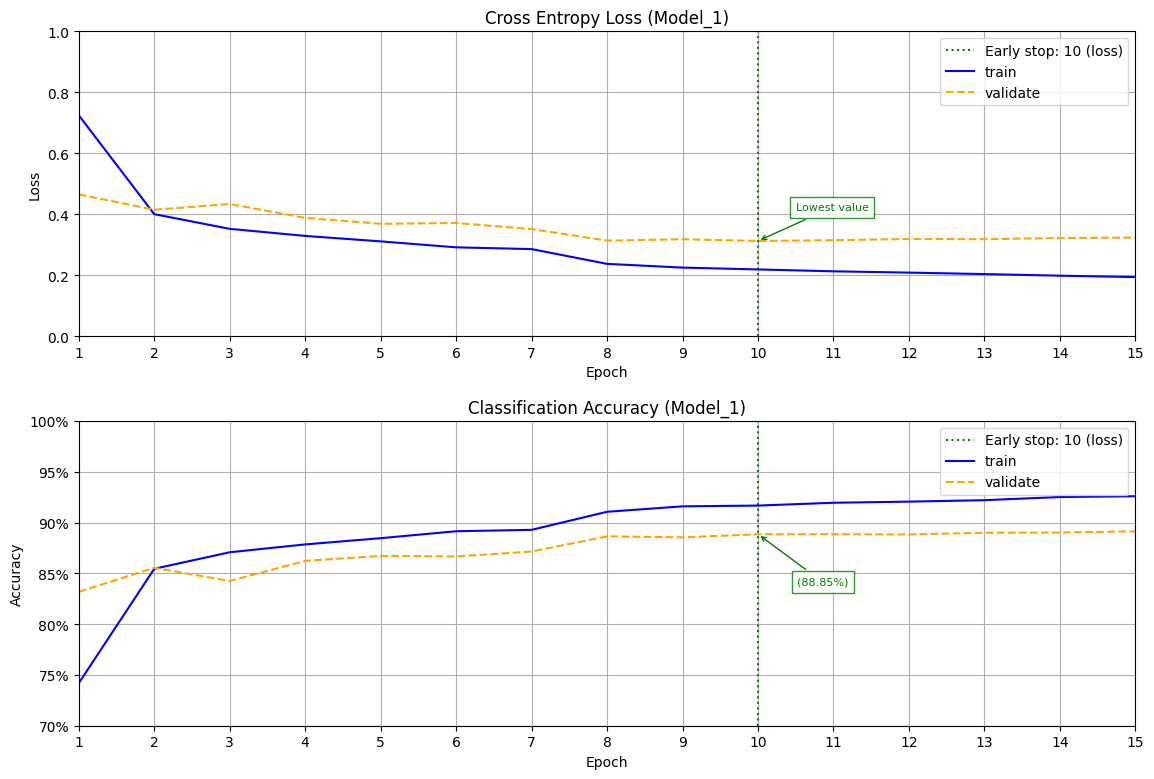

In [20]:
for name, models_h in models_his.items():
  #print(name)
  summarize(models_h, f"({name})", results[name])

## Reports

In [21]:
test_pred_values = {}
test_pred = {}
for name, models_h in models_his.items():
  print(name,models[name].name)
  test_pred[name] = models[name].predict(x_test, batch_size=batch_size, use_multiprocessing=True)
  test_pred_values[name] = tf.math.argmax(test_pred[name], axis=1)

Model_1 Model_1
20/20 [==============================] - 0s 12ms/step


Classification report for: 'Model_1'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.83      0.84      0.84      1000
1 - Trouser           0.99      0.97      0.98      1000
2 - Pullover          0.80      0.82      0.81      1000
3 - Dress             0.86      0.91      0.89      1000
4 - Coat              0.80      0.81      0.80      1000
5 - Sandal            0.98      0.96      0.97      1000
6 - Shirt             0.73      0.67      0.70      1000
7 - Sneaker           0.95      0.97      0.96      1000
8 - Bag               0.97      0.98      0.97      1000
9 - Ankle boot        0.96      0.96      0.96      1000

       accuracy                           0.89     10000
      macro avg       0.89      0.89      0.89     10000
   weighted avg       0.89      0.89      0.89     10000

Accuracy: 88.85%, ROC-AUC: 0.9914

Confusion matrix for: 'Model_1'


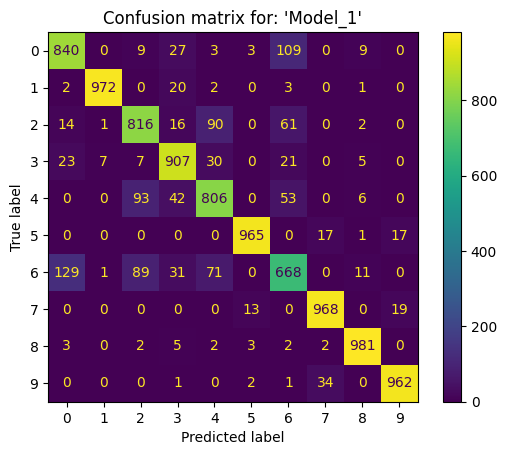

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 



In [22]:
target_names = [ f"{i} - {labels[i]:11}" for i in range(0, num_classes)]

for name in models_his.keys():
  print(f"Classification report for: '{name}'")
  print(classification_report(y_test, test_pred_values[name], target_names=target_names))
  cr = classification_report(y_test, test_pred_values[name], target_names=target_names, output_dict=True)
  roc_auc = roc_auc_score(y_test, test_pred[name], multi_class='ovo')
  print(f'Accuracy: {cr["accuracy"]:.2%}, ROC-AUC: {roc_auc:.4f}')
  print(f"\nConfusion matrix for: '{name}'")
  confusion_matrix(y_test, test_pred_values[name])
  ConfusionMatrixDisplay.from_predictions(y_test, test_pred_values[name])
  plt.title(f"Confusion matrix for: '{name}'")
  plt.show()
  print(list(map(lambda x: x.strip(),target_names)))
  print("-"*60,"\n")

## Порівняння моделей за val. accur.

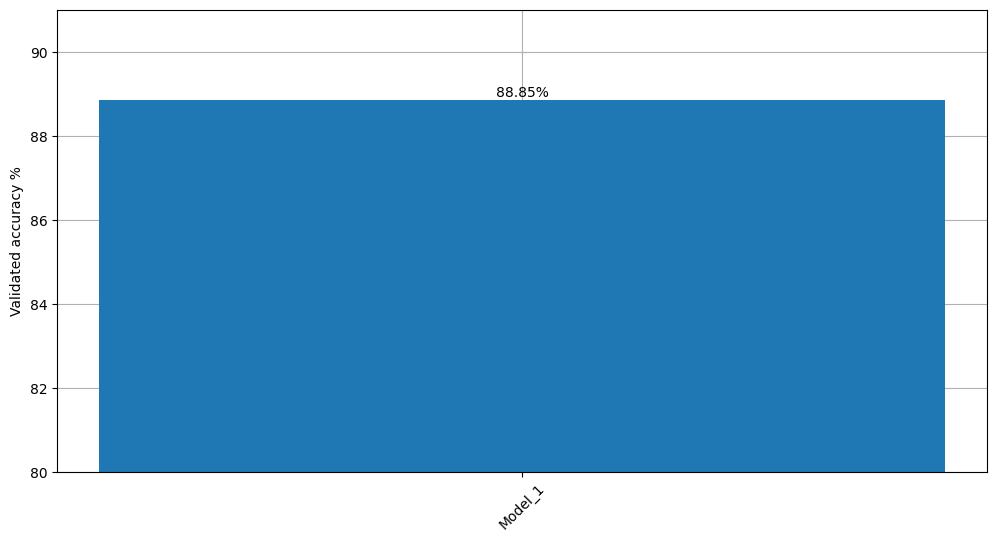

In [23]:
bar_y = [ results[m][1]*100 for m in models ]

plt.figure(figsize=(12,6))
plt.grid()
plt.gca().set_axisbelow(True)
colors = range(len(models))  # Choose the index of the color from the colormap
bars = plt.bar(x=models.keys(), height=bar_y, color=plt.cm.tab20(colors))
for bar, value in zip(bars, bar_y):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.4}%", ha='center', va='bottom')

plt.ylim(80,91)
plt.xticks(rotation=45)
plt.ylabel("Validated accuracy %")
plt.show()

## Візуалізація прогнозу

Model_1


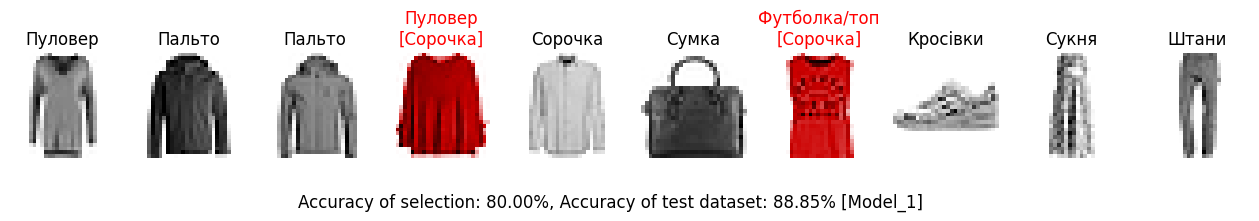

In [24]:
img_selected = 10
np.random.seed(43)
random_img_idx = np.random.randint(0, x_test.shape[0], size=img_selected)
#selected_model_name = list(models.keys())[0]
selected_model_name = "Model_1"
print(selected_model_name)
# Plot the images
colors = [(1, 1, 1), (0.8, 0, 0), (0, 0, 0)]  # white, red, black
custom_cmap = plt.cm.colors.LinearSegmentedColormap.from_list("CustomRed", colors, N=256)

plt.figure(figsize=(16, 5))
pred = 0
for i, idx in enumerate(random_img_idx, start=1):
    plt.subplot(1, img_selected, i)
    y_pred = test_pred_values[selected_model_name]

    correct = y_test[idx] == y_pred[idx]
    pred += int(correct)
    cmap = 'gray_r' if correct else custom_cmap
    color = "black" if correct else "red"
    plt.imshow(x_test[idx], cmap=cmap)
    title = labels_uk[y_test[idx]] if correct else f'{labels_uk[y_test[idx]]}\n[{labels_uk[test_pred_values[selected_model_name][idx]]}]'
    plt.title(title, color=color)
    plt.axis('off')

acc = pred/img_selected
plt.suptitle(f"Accuracy of selection: {acc:.2%}, Accuracy of test dataset: {results[selected_model_name][1]:.2%} [{selected_model_name}]")
plt.subplots_adjust(top=2.2)
plt.show()

## Висновок